In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
import matplotlib.pyplot as plt
import joblib  
from scipy.stats import uniform, randint
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
import seaborn as sns

In [2]:
df = pd.read_parquet('../data/processed/preprocessed_xgboost.parquet')
df.dropna(inplace = True)

# Remove recent lag features (lag_1 to lag_10) to reduce data leakage
lag_columns = [col for col in df.columns if 'lag_' in col and int(col.split('_')[-1]) <= 10]
df = df.drop(columns=lag_columns)

df.head()

,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,recommended_fee_fastestFee,recommended_fee_halfHourFee,recommended_fee_hourFee,recommended_fee_economyFee,recommended_fee_minimumFee,...,recommended_fee_fastestFee_lag_567,recommended_fee_fastestFee_lag_568,recommended_fee_fastestFee_lag_569,recommended_fee_fastestFee_lag_570,recommended_fee_fastestFee_lag_571,recommended_fee_fastestFee_lag_572,recommended_fee_fastestFee_lag_573,recommended_fee_fastestFee_lag_574,recommended_fee_fastestFee_lag_575,recommended_fee_fastestFee_lag_576
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-03-07 02:10:00,1599085.0,997970.50,3163.0,2605581.0,2.318812,3.0,3.0,3.0,2.0,1.0,...,2.0,2.0,3.0,2.0,2.0,2.0,4.0,3.0,2.0,2.0
2025-03-07 02:15:00,1669877.0,997939.25,3694.0,3401718.0,3.000000,3.0,3.0,3.0,2.0,1.0,...,3.0,2.0,2.0,3.0,2.0,2.0,2.0,4.0,3.0,2.0
2025-03-07 02:20:00,1653798.0,997925.25,3953.0,3979317.0,3.007259,4.0,3.0,3.0,2.0,1.0,...,3.0,3.0,2.0,2.0,3.0,2.0,2.0,2.0,4.0,3.0
2025-03-07 02:25:00,1323266.0,997994.75,1600.0,2293299.0,1.984234,2.0,2.0,2.0,2.0,1.0,...,4.0,3.0,3.0,2.0,2.0,3.0,2.0,2.0,2.0,4.0
2025-03-07 02:30:00,1485187.0,997943.50,2471.0,2943294.0,2.047671,3.0,3.0,3.0,2.0,1.0,...,4.0,4.0,3.0,3.0,2.0,2.0,3.0,2.0,2.0,2.0


### Define features and target

In [3]:
y = df["recommended_fee_fastestFee"]
X = df.drop(columns = "recommended_fee_fastestFee")

### Data split

In [4]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# last 10% as test
split_index = int(len(X) * 0.9)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Verify time separation
print('Train time range:', X_train.index.min(), 'to', X_train.index.max())
print('Test time range:', X_test.index.min(), 'to', X_test.index.max())

Train time range: 2025-03-07 02:10:00 to 2025-04-11 11:25:00
Test time range: 2025-04-11 11:30:00 to 2025-04-15 09:50:00


### XGBoost model

In [5]:
xgb_base = xgb.XGBRegressor(
    objective='reg:squarederror',
    tree_method='hist',
    n_jobs=-1
)

### Params

In [6]:
# param_dist = {
#     'n_estimators': randint(100, 600),
#     'learning_rate': uniform(0.01, 0.3),
#     'max_depth': randint(3, 10),
#     'subsample': uniform(0.6, 0.4),
#     'colsample_bytree': uniform(0.6, 0.4),
#     'gamma': uniform(0, 3),
#     'reg_alpha': uniform(0, 3),
#     'reg_lambda': uniform(0, 3)
# }
param_dist={
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0],
    'gamma': [0, 1, 5],
    'reg_lambda': [0, 1, 10],
}
# TimeSeries CV
tscv = TimeSeriesSplit(n_splits=5)
# mae + rmse
scoring = {
    'mae': 'neg_mean_absolute_error',
    'rmse': make_scorer(
        lambda y, y_pred: -np.sqrt(mean_squared_error(y, y_pred))
    )
}


### Random search

In [7]:
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=100,
    scoring=scoring,
    refit='mae',
    cv=tscv,
    verbose=1,
    return_train_score=True
)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamm...
                   n_iter=100,
                   param_distributions={'colsample_bytree': [0.7, 0.9, 1.0],
                                        'gamma': [0, 1, 5],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 300, 500],
                                        'reg_lambda': [0, 1, 10],
                                        'subsample': [0.7, 0.9, 1.0]},
                   refit='mae', return_train_score=True,
                   scoring={'mae': 'neg_mean_absolute_error',
                            'rmse': make_scorer(<lambda>, response_method='predict')},
                   verbose=1)

### Best model

In [8]:
best_model = random_search.best_estimator_
print("Best parameters (MAE):", random_search.best_params_)

Best parameters (MAE): {'subsample': 0.9, 'reg_lambda': 0, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 1.0}


### Prediction

In [9]:
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


MAE: 0.0246
RMSE: 0.1052


### Plot

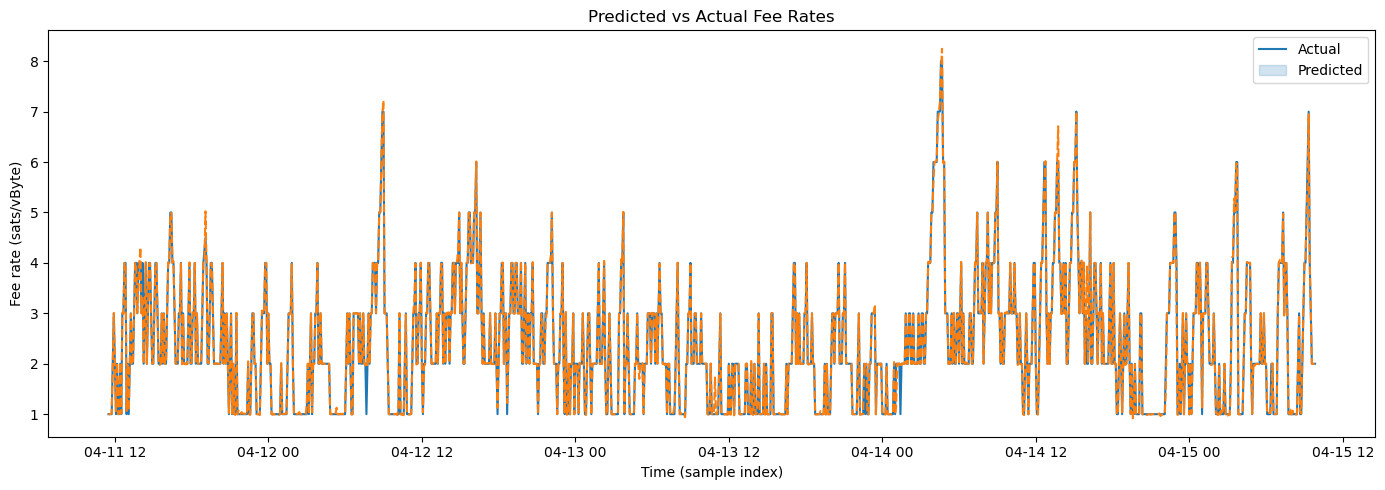

In [10]:
result_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
}, index=y_test.index)

plt.figure(figsize=(14, 5))
sns.lineplot(data=result_df)
plt.title('Predicted vs Actual Fee Rates')
plt.xlabel('Time (sample index)')
plt.ylabel('Fee rate (sats/vByte)')
plt.legend(['Actual', 'Predicted'])
plt.tight_layout()
plt.show()